In [1]:
import sys; sys.path.append("..")
from epi_model import *

In [2]:
#my_fn = '2000 raw_stats-alph=0.1-high school2.pickle'

In [3]:
tnets = [
    temporalNetwork.load('high school').range(1,2),
    temporalNetwork.load('high school2')
]

In [4]:
tnets[0].Nnodes

310

In [5]:
tnets[0].edgelist.shape

(94676, 3)

In [6]:
tt = temporalNetwork.load('high school')

In [7]:
times = tt.edgelist[:,0]

In [8]:
times[(times>2500)&(times<7000)].shape

(94676,)

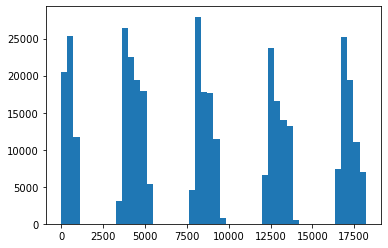

In [9]:
plt.hist(tt.edgelist[:,0], bins=50);

In [10]:
from threading import Thread

In [11]:
daily_aranges = [0.05, 0.1, 0.15, 0.2]

In [12]:
params.covid_estimate

{'s2e': 0.0006, 'e2i': 2.3148148148148147e-05, 'i2r': 1.6534391534391536e-05}

In [13]:
ms = defaultdict(list)

In [24]:
tnets[0].Nnodes

310

In [25]:
tnets[1].Nnodes

784

In [14]:
strats = [
    sampling.friendHighDegClose,
    sampling.friendClose,
]

def start_worker(S2E, tneti):
    tnet = tnets[tneti]
    global ms
    
    print('loading network...')
    
    p = dict(params.covid_estimate)
    p['s2e'] = params.daily_to_momentary(tnet, S2E)
    sim = simulations.SEIR_daily(tnet, p)

    for VACC_P in [0.05, 0.10, 0.20]:
        N_T_VACC = int(tnet.Nnodes * VACC_P)

        for i, strat in enumerate(strats):
            NAME = strat.__name__#+("_%s" % i)
            NAME = (tneti, S2E, VACC_P, NAME)
            print("Starting on ", NAME)

            for i in range( 200 - len(ms[NAME]) ):
                if (i+1)%20 == 0:
                    print("simulation %s" % (i+1))

                sim.init_attributes()

                to_vacc = strat(sim, vaccinateN=N_T_VACC)

                for x in to_vacc:
                    sim.state_change(x, 'vacc')

                for who in sample([x for x in range(tnet.Nnodes) if not sim.vacc[x]], 20):
                    sim.state_change(who, 'inf')

                sim.run(100)
                ms[NAME].append( sim.meas )

In [15]:
from threading import Thread

In [16]:
def _cart_prod(L1, L2):
    if L1 == []:
        return L2
    if L2 == []:
        return L1
    
    for x in L1:
        for y in L2:
            if type(x) != list:
                x = [x]
            if type(y) != list:
                y = [y]
            
            yield x+y
                
def cart_prod(L1, L2):
    return list(_cart_prod(L1,L2))
def cp(L1, L2):
    return cart_prod(L1, L2)
def cp(*args):
    res = args[0]
    for a in args[1:]:
        res = list(_cart_prod(res,a))
    return res

In [17]:
argsx = cp(
    [0.05, 0.1, 0.2], # S2Es
    [0,1]
)

In [18]:
threads = []
for S2E, tneti in argsx:
    t = Thread(target=start_worker, args=(S2E, tneti))
    t.start()
    threads.append(t)
        
for t in threads:
    t.join()

loading network...
loading network...
loading network...
loading network...
loading network...
loading network...
Starting on  (0, 0.1, 0.05, 'friendHighDegClose')
Starting on  (0, 0.2, 0.05, 'friendHighDegClose')
Starting on  (0, 0.05, 0.05, 'friendHighDegClose')
simulation 20
simulation 20
simulation 20
simulation 40
simulation 40
simulation 40
Starting on  (1, 0.1, 0.05, 'friendHighDegClose')
Starting on  (1, 0.2, 0.05, 'friendHighDegClose')
simulation 60
simulation 60
simulation 60
simulation 80
Starting on  (1, 0.05, 0.05, 'friendHighDegClose')
simulation 100
simulation 80
simulation 80
simulation 120
simulation 100
simulation 100
simulation 140
simulation 160
simulation 120
simulation 120
simulation 180
simulation 200
Starting on  (0, 0.2, 0.05, 'friendClose')
simulation 140
simulation 140
simulation 20
simulation 160
simulation 160
simulation 40
simulation 60
simulation 180simulation 180

simulation 80
simulation 100
simulation 200
Starting on simulation 200 
(0, 0.05, 0.05, 'fr

In [22]:
len(ms)

36

In [19]:
len(ms[list(ms.keys())[0]])

200

In [21]:
if True:
    import pickle
    with open('G:\\My Drive\\2020 ORGANISATION\\0. right now right now\\31 disease contact spread\\0.1 analysis\\full_run_2.pickle', 'wb') as outf:
        pickle.dump( ms, outf )